In [ ]:
# default_exp calibrate

# Calibrate

> Calibration for the Open Source DIY Hyperspectral Imager

First, the use of a common file format for storing calibration data is discussed followed by functions for calibration. 

In [117]:
#hide
from nbdev.showdoc import *

## Common File Format
First, we convert all calibration files to a common format (HDF5). Numpy arrays inside this file can be accessed like a dictionary. We then only package HDF5 calibration files for PyPi. 


### wavesoln.npz $\rightarrow$ wave_soln.hdf5

`wavesoln.npz` contains `wavecal` and `newwave`.

wavecal has shape (896, 772)
newwave has shape (818,)
File has entries: ['newwave', 'wavecal']


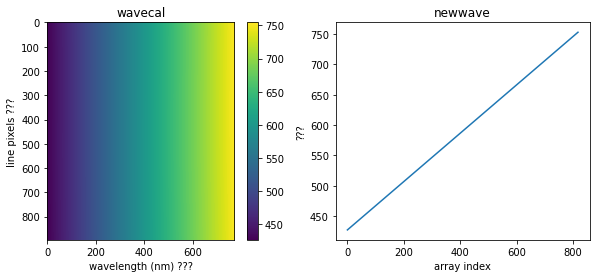

In [79]:

import numpy as np
import matplotlib.pyplot as plt

npzfile = np.load("cal_files/wavesoln.npz")
wavecal = npzfile["wavecal"]
newwave = npzfile["newwave"]

import h5py
with h5py.File("cal_files/wave_soln.hdf5", "w") as f:
    dset = f.create_dataset("wavecal",shape=wavecal.shape,dtype=np.float64)
    dset[...] = wavecal
    print(f'wavecal has shape {wavecal.shape}')
    dset2 = f.create_dataset("newwave",shape=newwave.shape,dtype=np.float64)
    dset2[...] = newwave
    print(f'newwave has shape {newwave.shape}')

# check if we can open the HDF5 files
with h5py.File("cal_files/wave_soln.hdf5", "r") as f:
    print(f'File has entries: {list(f.keys())}')

    plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    plt.subplot(1,2,1); plt.title('wavecal')
    plt.imshow(f['wavecal'])
    plt.colorbar()
    plt.xlabel('wavelength (nm) ???'); plt.ylabel('line pixels ???')
    

    plt.subplot(1,2,2); plt.title('newwave')
    plt.plot(f['newwave'])
    plt.xlabel('array index'); plt.ylabel('???')

### arc.fits $\rightarrow$ arc.hdf5

`arc.fits` contains `hdulist[0].data` which is called `arcimg`. `hdulist` has length 1. 

arcimg has shape (896, 772)
File has entries: ['arc_img']


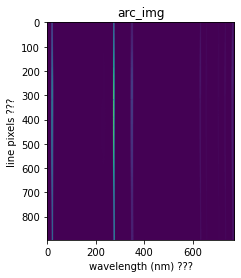

In [4]:

from astropy.io import fits as fitsio
hdulist = fitsio.open("cal_files/arc.fits")
arcimg = np.rot90(hdulist[0].data, -1)

import h5py
with h5py.File("cal_files/arc.hdf5", "w") as f:
    dset = f.create_dataset("arc_img",shape=arcimg.shape,dtype=np.float64)
    dset[...] = arcimg
    print(f'arcimg has shape {arcimg.shape}')


# check if we can open the HDF5 files
with h5py.File("cal_files/arc.hdf5", "r") as f:
    print(f'File has entries: {list(f.keys())}')
    
    plt.title('arc_img')
    plt.imshow(f['arc_img'])
    plt.xlabel('wavelength (nm) ???'); plt.ylabel('line pixels ???')

### hgar_linelist_cfht.mat $\rightarrow$ HgAr_lines.hdf5

`hgar_linelist_cfht.mat` contains `#refs#`, `Species`, and `wavelength`. I don't know how to deal with `#refs#` and `Species`. 

File has entries: ['#refs#', 'Species', 'wavelength']
wavelength has shape (252,)


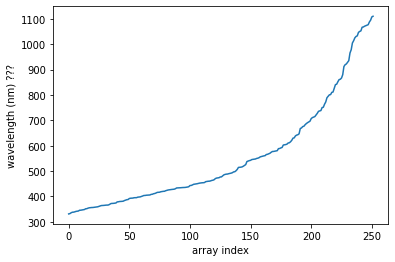

In [5]:

with h5py.File('cal_files/hgar_linelist_cfht.mat','r') as f:
    print(f'File has entries: {list(f.keys())}')

    with h5py.File('cal_files/HgAr_lines.hdf5','w') as f2:
        wavelength = f.get('wavelength')[0,:] # original shape is (1,252)
        dset = f2.create_dataset("wavelength",shape=wavelength.shape,dtype=np.float64)
        dset[...] = wavelength
        print(f'wavelength has shape {wavelength.shape}')

with h5py.File('cal_files/HgAr_lines.hdf5','r') as f:
        plt.plot(np.array(f['wavelength'])/10)
        plt.xlabel('array index')
        plt.ylabel('wavelength (nm) ???')

  #data = np.array( f.get('hypercube') )

In [13]:
A = np.array([[1,2,3,4],[5,6,7,8]])
print(A)
print(f'shape is {A.shape}')
print(f'first row is {A[0,:]}')

[[1 2 3 4]
 [5 6 7 8]]
shape is (2, 4)
first row is [1 2 3 4]


## The Calibration Module



In [8]:
#export
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate
from fastprogress.fastprogress import master_bar, progress_bar
import h5py

Fitting Arc Lines in each col...


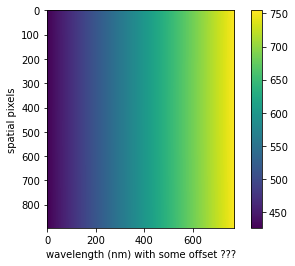

In [88]:


def NGaussFunc(x, *params):  # x0 pk width
    y = np.zeros_like(x)
    for i in range(0, len(params) - 1, 3):
        ctr = params[i]
        amp = params[i + 1]
        wid = params[i + 2]
        y = y + amp * np.exp(-((x - ctr) / wid) ** 2)
    return y + params[-1]

def fit_arc_lines(arcimg, spatial_col_skip=1, wavecalfile=""):
    arcimg = arcimg * 1.0 / np.max(arcimg, axis=1)[:, None]
    spatialaxis = np.arange(0, arcimg.shape[0])
    waveaxis = np.arange(0, arcimg.shape[1])

    arcgausfits = np.zeros((len(range(1, arcimg.shape[0], spatial_col_skip)) + 1, 28))

    spec = arcimg[0, :]
    peaks, properties = find_peaks(spec, height=0.01, width=1.5, prominence=0.01)

    
    y0 = np.zeros((peaks.size * 3))
    y0[0::3] = peaks
    y0[1::3] = properties["peak_heights"]
    y0[2::3] = properties["widths"] * 0.5
    y0 = np.append(y0, 0.02)

    arcgausfits[0, :], pcov = curve_fit(NGaussFunc, waveaxis, spec, p0=y0)
    i = 0
    print("Fitting Arc Lines in each col...")
    for col in progress_bar(range(1, arcimg.shape[0], spatial_col_skip)):
        i += 1
        spec = arcimg[col, :]
        y0 = arcgausfits[i - 1, :]
        arcgausfits[i, :], pcov = curve_fit(NGaussFunc, waveaxis, spec, p0=y0)

    pos = arcgausfits[:, range(0, arcgausfits.shape[1] - 1, 3)]
    peakheight = arcgausfits[:, range(0, arcgausfits.shape[1] - 1, 3)]
    width = arcgausfits[:, range(2, arcgausfits.shape[1] - 1, 3)]

    smoothed_pos = np.zeros_like(pos)
    for row in progress_bar(range(0, pos.shape[1])):
        smoothed_pos[:, row] = savgol_filter(pos[:, row], 21, 3)

    spectral_lines = np.asarray([4358.328, 5460.735, 5769.598, 5790.663, 6965.4307,
                                7067.2175, 7272.9359, 7383.9805, 7503.8691]) / 10

    wavecal = np.zeros((smoothed_pos.shape[0], waveaxis.shape[0]))
    p = []
    for i in range(0, smoothed_pos.shape[0]):
        z = np.polyfit(smoothed_pos[i, :], spectral_lines, 4)
        p.append(np.poly1d(z))
        wavecal[i, :] = p[-1](waveaxis)

    if True:
        plt.imshow(wavecal)
        plt.xlabel('wavelength (nm) with some offset ???')
        plt.ylabel('spatial pixels')
        plt.colorbar()
        plt.show()

    minwave = wavecal.min(axis=1).max()
    maxwave = wavecal.max(axis=1).min()
    minwavedelta = np.diff(wavecal, axis=1).min()

    newwave = np.arange(minwave, maxwave, minwavedelta)

    interpimg = np.zeros((wavecal.shape[0], newwave.shape[0]))

    for col in range(0, wavecal.shape[0]):
        f = interpolate.interp1d(wavecal[col, :], arcimg[col, :])
    interpimg[col, :] = f(newwave)

    result = {
        "wavecal": wavecal,
        "pos": pos,
        "peakheight": peakheight,
        "width": width,
        "smoothed_pos": smoothed_pos,
        "newwave": newwave,
    }
    if len(wavecalfile):
        np.savez(wavecalfile, **result)

    return result

with h5py.File("cal_files/arc.hdf5", "r") as f:
    arcimg = np.array(f['arc_img'])

    result_orig = fit_arc_lines(arcimg)


### Partly refactored functions

In [22]:
def linearise_wavelength(raw:np.ndarray, cal_file:h5py.File) -> np.ndarray:
    """Linearise `raw` by wavelength ??? Defined but not used."""
    with h5py.File('cal_files/wave_soln.hdf5','r') as f:
        wavecal = f['wavecal']
        newwave = f['newwave']

        rows = wavecal.shape[0]; cols = newwave.shape[0]
        interp_img = np.zeros((rows,cols))
        print(f'interp_img has shape {interpimg.shape}')

        for i in range(rows):
            g = interpolate.interp1d( wavecal[i,:], raw[i,:] )
            interp_img[i,:] = g(newwave)
        
        return interp_img

(9,)

In [117]:
#export

def sum_gaussians(x:"wavelength np.array", 
                    *args:"amplitude, peak position, peak width, constant") -> np.array:
    split = len(args)//3
    A   = args[0:split]         # amplitude
    mu  = args[split:2*split]   # peak position
    sigma = args[split*2:-1]    # peak stdev
    c   = args[-1]              # offset
    return np.array( [A[i] * np.exp( - np.square( (x - mu[i])/sigma[i] ) ) 
                        for i in range(len(A))] ).sum(axis=0) + c


def fit_arc_lines2(arc_file:str = "cal_files/arc.hdf5", wave_save_file:str = None, skip:int = 1, 
                    show:bool = True) -> dict:
    """Fit a bunch of guassians on top of a spectrum. ???"""
    with h5py.File(arc_file, "r") as f:
        arc_img = np.array(f['arc_img'],dtype=np.float64)

        # normalise the image?
        arc_img /= np.max(arc_img, axis = 1)[:, None]
        
        # rows -> spatial axis, cols -> wavelength axis
        rows, cols = arc_img.shape
        x_array, wavelengths = np.arange(rows), np.arange(cols)

        # init arrays. why 28 cols?
        # took a while, but this is rows*(9peaks*3arrays+1constant)
        # the assumption here is that there will only be 9 peaks. 
        arc_gauss_fit = np.zeros((rows//skip,28))

        # init with first pixel's spectrum
        # does spec mean species?
        spec    = arc_img[0,:]
        mu, props = find_peaks(spec, height = 0.01, width = 1.5, prominence = 0.01)
        A       = props["peak_heights"]
        sigma   = 0.5 * props["widths"]
        c       = 0.02
        params0 = [*A,*mu,*sigma,c]

        

        if show:
            plt.subplots(nrows=1,ncols=2,figsize=(10,5))
            plt.subplot(1,2,1)
            plt.plot(wavelengths,spec)
            plt.plot(mu, A, 'r*')
            plt.xlabel('wavelength (nm) with some offset ???')
            plt.ylabel('normalised amplitude')
            #plt.show()

        #breakpoint()
        #arc_gauss_fit[0,:], _ = curve_fit(sum_gaussians, wavelengths, spec, p0=params)
        print('Fit arc lines for each spatial pixel')
        #skip = rows
        for i in progress_bar(range(0,rows,skip)):
            params = params0 if i == 0 else arc_gauss_fit[i-1,:]
            arc_gauss_fit[i,:], _ = curve_fit(sum_gaussians, wavelengths, arc_img[i,:], p0=params)

        split = len(params0)//3
        A     = arc_gauss_fit[:,:split]
        mu    = arc_gauss_fit[:,split:2*split]
        sigma = arc_gauss_fit[:,2*split:-1]

        # why smooth the peak centres?
        # shape is (spatial pixels,9 peaks found)
        smooth_mu = np.zeros_like(mu)
        for j in range(split):
            smooth_mu[:,j] = savgol_filter(mu[:,j], 21, 3)

        spectral_lines = np.asarray([4358.328, 5460.735, 5769.598, 5790.663, 6965.4307,
                                7067.2175, 7272.9359, 7383.9805, 7503.8691]) / 10

        wave_cal = np.zeros((rows,cols))

        poly_funcs = [np.poly1d( np.polyfit(smooth_mu[i,:], spectral_lines, 4) ) for i in range(rows)]
        #breakpoint()
        wave_cal = np.array([p(wavelengths) for p in poly_funcs])

        # what is the reasoning behind .max() after min()? and vice versa
        min_wavelength = wave_cal.min(axis=1).max()
        max_wavelength = wave_cal.max(axis=1).min()
        delta_wavelength = np.diff(wave_cal, axis=1).min()

        #breakpoint()
        newwave = np.arange(min_wavelength, max_wavelength, delta_wavelength)
        interp_img = np.zeros((rows,len(newwave)))

        f = [interpolate.interp1d(wave_cal[i,:], arc_img[i,:]) for i in range(rows)]
        for i in range(rows):
            interp_img[i,:] = f[i](newwave)

        if show:
            plt.subplot(1,2,2)
            plt.imshow(wave_cal)
            plt.xlabel('wavelength (nm) with some offset ???')
            plt.ylabel('spatial pixels')
            plt.colorbar()
            plt.show()

        result = {  "wavecal": wave_cal,
                    "pos": mu,
                    "peakheight": A,
                    "width": sigma,
                    "smoothed_pos": smooth_mu,
                    "newwave": newwave}

        if wave_save_file:
            with h5py.File(wave_save_file, "w") as f:
                for k, v in result.items():
                    f.create_dataset(k, data=np.array(v, dtype=np.float64))

        return result



Fit arc lines for each spatial pixel


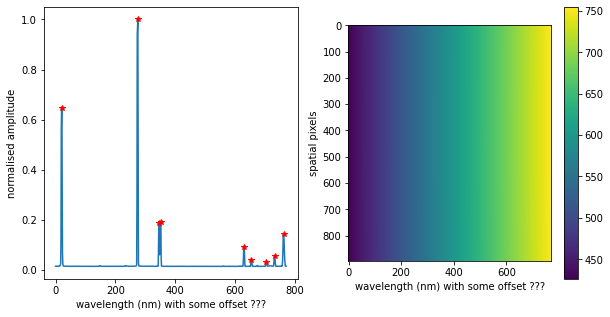

In [116]:
result_new = fit_arc_lines2()

### Testing equality of the original vs refactored.

Outputs are the same

In [115]:
result_orig['pos'], result_new['pos']

(array([[ 20.28062531, 274.1020825 , 345.94287303, ..., 704.93987811,
         732.24011188, 762.40439901],
        [ 20.30565116, 274.11299358, 345.961027  , ..., 704.95826221,
         732.19055026, 762.35044483],
        [ 20.29659573, 274.11149471, 345.95030682, ..., 704.92574909,
         732.22739195, 762.39392452],
        ...,
        [ 21.63075813, 275.46631003, 347.24086015, ..., 706.06504944,
         733.35832852, 763.48530985],
        [ 21.62694754, 275.49230029, 347.17607768, ..., 706.06156462,
         733.36353224, 763.49717647],
        [ 21.63454679, 275.43407553, 347.17607992, ..., 706.11162245,
         733.40356372, 763.4755657 ]]),
 array([[ 20.28062531, 274.1020825 , 345.94287303, ..., 704.93987811,
         732.24011188, 762.40439901],
        [ 20.30565116, 274.11299358, 345.961027  , ..., 704.95826221,
         732.19055026, 762.35044483],
        [ 20.29659573, 274.11149471, 345.95030682, ..., 704.92574909,
         732.22739195, 762.39392452],
        ...,


In [110]:
sum_gaussians(np.arange(100),*np.array([10,10,20,20,10,10,10])) # amp, ctr, width, const


array([10.36631278, 10.54103694, 10.7832779 , 11.11152425, 11.54609481,
       12.10798449, 12.81716842, 13.69039048, 14.73855517, 15.96394559,
       17.35758882, 18.89716132, 20.54584848, 22.25252788, 23.95352652,
       25.57601566, 27.04287578, 28.27862371, 29.21578878, 29.80099667,
       30.        , 29.80099667, 29.21578878, 28.27862371, 27.04287578,
       25.57601566, 23.95352652, 22.25252788, 20.54584848, 18.89716132,
       17.35758882, 15.96394559, 14.73855517, 13.69039048, 12.81716842,
       12.10798449, 11.54609481, 11.11152425, 10.7832779 , 10.54103694,
       10.36631278, 10.24310357, 10.15814108, 10.10083521, 10.06302223,
       10.03860908, 10.02318458, 10.01364656, 10.00787338, 10.0044526 ,
       10.0024682 , 10.0013411 , 10.00071426, 10.00037287, 10.0001908 ,
       10.0000957 , 10.00004705, 10.00002267, 10.00001071, 10.00000496,
       10.00000225, 10.000001  , 10.00000044, 10.00000019, 10.00000008,
       10.00000003, 10.00000001, 10.00000001, 10.        , 10.  

In [102]:
NGaussFunc(np.arange(100),*np.array([20,10,10,20,10,10])) # ctr, amp, width, const

array([10.36631278, 10.54103694, 10.7832779 , 11.11152425, 11.54609481,
       12.10798449, 12.81716842, 13.69039048, 14.73855517, 15.96394559,
       17.35758882, 18.89716132, 20.54584848, 22.25252788, 23.95352652,
       25.57601566, 27.04287578, 28.27862371, 29.21578878, 29.80099667,
       30.        , 29.80099667, 29.21578878, 28.27862371, 27.04287578,
       25.57601566, 23.95352652, 22.25252788, 20.54584848, 18.89716132,
       17.35758882, 15.96394559, 14.73855517, 13.69039048, 12.81716842,
       12.10798449, 11.54609481, 11.11152425, 10.7832779 , 10.54103694,
       10.36631278, 10.24310357, 10.15814108, 10.10083521, 10.06302223,
       10.03860908, 10.02318458, 10.01364656, 10.00787338, 10.0044526 ,
       10.0024682 , 10.0013411 , 10.00071426, 10.00037287, 10.0001908 ,
       10.0000957 , 10.00004705, 10.00002267, 10.00001071, 10.00000496,
       10.00000225, 10.000001  , 10.00000044, 10.00000019, 10.00000008,
       10.00000003, 10.00000001, 10.00000001, 10.        , 10.  